In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Patch
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel
from scipy.special import erf
from scipy.stats import gaussian_kde
from tqdm import tqdm
import h5py

In [2]:
# Load results from AR fit to effective spin distributions
precomputed_effective_data = h5py.File("./../data/ar_Xeff_Xp_summary.hdf","r")
Xeffs = precomputed_effective_data['posterior/Xeffs'][()]
Xps = precomputed_effective_data['posterior/Xps'][()]
f_Xeffs = precomputed_effective_data['posterior/f_Xeffs'][()]
f_Xps = precomputed_effective_data['posterior/f_Xps'][()]

# Construct normalized probability distributions
p_Xeff_direct = f_Xeffs/np.trapz(f_Xeffs,Xeffs,axis=0)
p_Xp_direct = f_Xps/np.trapz(f_Xps,Xps,axis=0)

In [3]:
# Also load results from AR fit to underlying *component spin* distributions
precomputed_component_data = h5py.File("./../data/ar_chi_cost_summary.hdf","r")
chis = precomputed_component_data['posterior/chis'][()]
costs = precomputed_component_data['posterior/costs'][()]
f_chis = precomputed_component_data['posterior/f_chis'][()]
f_costs = precomputed_component_data['posterior/f_costs'][()]

# We will also need information about the mass distribution in order to compute effective spins,
# which depend on the inferred mass ratio distribution
component_alpha = precomputed_component_data['posterior/alpha'][()]
component_bq = precomputed_component_data['posterior/bq'][()]
component_mu_m1 = precomputed_component_data['posterior/mu_m1'][()]
component_sig_m1 = precomputed_component_data['posterior/sig_m1'][()]
component_log_f_peak = precomputed_component_data['posterior/log_f_peak'][()]
component_mMin = precomputed_component_data['posterior/mMin'][()]
component_mMax = precomputed_component_data['posterior/mMax'][()]
component_log_dmMin = precomputed_component_data['posterior/log_dmMin'][()]
component_log_dmMax = precomputed_component_data['posterior/log_dmMax'][()]

In [4]:
# Using fits to component spins, we will numerically derive the implied effective spin distributions
# Do this by repeatedly drawing random component spin magnitudes, tilts, and binary mass ratios
# In preparation, construct spin magnitude and tilt probability distributions
p_chis = f_chis/np.trapz(f_chis,chis,axis=0)
p_costs = f_costs/np.trapz(f_costs,costs,axis=0)

# Also construct CDFs
chi_cdf = np.cumsum(p_chis[1:,:]*np.diff(chis)[:,np.newaxis],axis=0)
chi_cdf /= chi_cdf[-1,:]

cost_cdf = np.cumsum(p_costs[1:,:]*np.diff(costs)[:,np.newaxis],axis=0)
cost_cdf /= cost_cdf[-1,:]

In [5]:
# Number of random draws per population sample
nSamples_per_trace = 10000

# Instantiate arrays to hold derived effective spins
Xeffs_from_component_spins = np.zeros((nSamples_per_trace,component_alpha.size))
Xps_from_component_spins = np.zeros((nSamples_per_trace,component_alpha.size))

# Loop across posterior samples
for i in tqdm(range(component_alpha.size)):
        
    # Construct the implied CDF for primary masses and draw random m1 samples
    m1_grid = np.linspace(2.,100.,500)
    f_m1 = massModel(m1_grid,
                     component_alpha[i],
                     component_mu_m1[i],
                     component_sig_m1[i],
                     10.**component_log_f_peak[i],
                     component_mMax[i],
                     component_mMin[i],
                     10.**component_log_dmMax[i],
                     10.**component_log_dmMin[i]
                    )
    p_m1 = f_m1/np.trapz(f_m1,m1_grid)
    cdf_m1 = np.cumsum(p_m1*np.diff(m1_grid)[0])
    m1s = np.interp(np.random.random(nSamples_per_trace),cdf_m1,m1_grid)
    
    # Draw random m2 samples
    bq = component_bq[i]
    m2s = (2.**(1.+bq) + np.random.random(nSamples_per_trace)*(m1s**(1.+bq) - 2.**(1.+bq)))**(1./(1.+bq))
    qs = m2s/m1s

    # And random spin magnitude/tilt samples
    a1_draws = np.interp(np.random.random(nSamples_per_trace),chi_cdf[:,i],chis[1:])
    a2_draws = np.interp(np.random.random(nSamples_per_trace),chi_cdf[:,i],chis[1:])
    cost1_draws = np.interp(np.random.random(nSamples_per_trace),cost_cdf[:,i],costs[1:])
    cost2_draws = np.interp(np.random.random(nSamples_per_trace),cost_cdf[:,i],costs[1:])
    sint1_draws = np.sqrt(1.-cost1_draws**2)
    sint2_draws = np.sqrt(1.-cost2_draws**2)
    
    # Compute corresponding effective spins and store
    Xeffs_from_component_spins[:,i] = (a1_draws*cost1_draws + qs*a2_draws*cost2_draws)/(1.+qs)
    Xps_from_component_spins[:,i] = np.maximum(a1_draws*sint1_draws,
                                              qs*((3.+4.*qs)/(4.+3.*qs))*a2_draws*sint1_draws)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:18<00:00, 237.85it/s]


In [6]:
# For each population sample, we now have an ensemble of chi-effective values
# KDE these to get p(chi-effective)

# First set up a grid of effective spins and instantiate an array to hold results
Xeff_grid = np.linspace(-1,1,300)
p_Xeffs = np.zeros((component_alpha.size,Xeff_grid.size))

# Loop across samples
for i in range(component_alpha.size):
    
    # For each sample, construct KDE and evaluate
    Xeff_kde = gaussian_kde(Xeffs_from_component_spins[:,i],bw_method=0.1)
    p_Xeffs[i,:] = Xeff_kde(Xeff_grid)

In [7]:
# Do the same thing for effective precessing spins
# Note that the derived chi-p distribution necessarily vanishes at chi_p = 0 and chi_p = 1
# A Gaussian KDE will struggle to accurately capture these boundary effects
# We will therefore instead construct and evaluate our KDE in *logit(chi_p)* space, which occupies the unbounded interval
# from (-inf,inf). Following this, we will transform back to chi_p space with an appropriate Jacobian

# Instantiate a grid of chi_ps, and apply logit transform
Xp_grid = np.linspace(0.001,0.999,300)
logit_Xp_grid = np.log(Xp_grid/(1.-Xp_grid))

# Create array to hold results
p_Xps = np.zeros((component_alpha.size,Xp_grid.size))

# Loop across samples
for i in tqdm(range(component_alpha.size)):
    
    # For each population sample, apply logit transform to chi_p draws and construct KDE
    logit_Xps = np.log(Xps_from_component_spins[:,i]/(1.-Xps_from_component_spins[:,i]))
    logit_Xp_kde = gaussian_kde(logit_Xps,bw_method=0.1)
    
    # Evaluate KDE on logit-transformed grid
    p_logit_Xp = logit_Xp_kde(logit_Xp_grid)
    
    # Compute jacobian d(logit chi_p)/d(chi_p)
    jacobian = 1./(Xp_grid*(1.-Xp_grid))
    
    # Transform back to physical chi_p space and store
    p_Xps[i,:] = p_logit_Xp*jacobian

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:54<00:00, 82.71it/s]


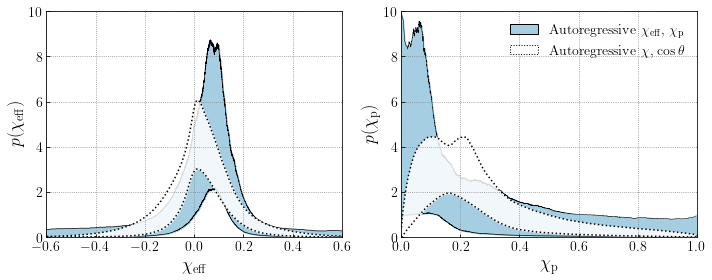

In [8]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(121)
    
ax.plot(Xeffs,np.quantile(p_Xeff_direct,0.05,axis=1),color='black',lw=0.7,zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff_direct,0.95,axis=1),color='black',lw=0.7,zorder=1)
ax.fill_between(Xeffs,np.quantile(p_Xeff_direct,0.05,axis=1),
                np.quantile(p_Xeff_direct,0.95,axis=1),color='#a6cee3',zorder=-1)

ax.plot(Xeff_grid,np.quantile(p_Xeffs,0.05,axis=0),color='black',ls=':')
ax.plot(Xeff_grid,np.quantile(p_Xeffs,0.95,axis=0),color='black',ls=':')
ax.fill_between(Xeff_grid,np.quantile(p_Xeffs,0.05,axis=0),
                np.quantile(p_Xeffs,0.95,axis=0),color='white',alpha=0.85)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,10)
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

ax = fig.add_subplot(122)
    
ax.plot(Xps,np.quantile(p_Xp_direct,0.05,axis=1),color='black',lw=0.7,zorder=1)
ax.plot(Xps,np.quantile(p_Xp_direct,0.95,axis=1),color='black',lw=0.5,zorder=1)
ax.fill_between(Xps,np.quantile(p_Xp_direct,0.05,axis=1),
                np.quantile(p_Xp_direct,0.95,axis=1),
                color='#a6cee3',zorder=-1)

ax.plot(Xp_grid,np.quantile(p_Xps,0.05,axis=0),color='black',ls=':')
ax.plot(Xp_grid,np.quantile(p_Xps,0.95,axis=0),color='black',ls=':')
ax.fill_between(Xp_grid,np.quantile(p_Xps,0.05,axis=0),
                np.quantile(p_Xps,0.95,axis=0),
                color='white',alpha=0.85)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,10)
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{p})$',fontsize=18)

handles = [Patch(facecolor="#a6cee3", edgecolor='black', label="Autoregressive $\chi_\mathrm{eff}$, $\chi_\mathrm{p}$"),
           Patch(facecolor="white", edgecolor='black',linestyle=':',label=r"Autoregressive $\chi$, $\cos\theta$")]
ax.legend(handles=handles,fontsize=14)

plt.tight_layout()
plt.savefig('figure_14.pdf',bbox_inches='tight')
plt.show()